In [ ]:
import enum
import os
import zipfile
import gzip
import json
from glob import glob
import re

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

In [ ]:
# dead code
class WidType(enum.StrEnum):
    IMG = "img",
    FIGURE = "figure",
    S_TEXT = "StaticText",
    SEP = "separator",
    BR = "LineBreak", # <br>
    LINK = "link",
    LIST_ITEM = "listitem",
    HEADING = "heading",
    PARAGRAPH = "paragraph"



## Loading files

In [532]:
#files = os.path.join(d1_path, "train_split_web7k")
base_data_path = Path(r"C:\Users\70133\.cache\huggingface\hub\datasets--biglab--webui-7k\snapshots\60f7b3c4b9409f75551664adc1564625dfc33c2e\dataset1")
files = base_data_path / 'train_split_web7k'
print(files)
print("files number", len(os.listdir(files)))

C:\Users\70133\.cache\huggingface\hub\datasets--biglab--webui-7k\snapshots\60f7b3c4b9409f75551664adc1564625dfc33c2e\dataset1\train_split_web7k
files number 5420


In [ ]:
# Load pages metadata
os.chdir(r"C:\Users\70133\Documents\GitHub\jarvis-core")

with open('webui/metadata/screenclassification/class_map_enrico.json', 'r') as f:
    labels = json.load(f)["idx2Label"].values()
#dtypes = {**{'page_id': object, 'file': object}, **dict([(x, np.float64) for x in labels])}
dtypes = {**{'page_id': np.int64, 'file': object}, **dict([(x, np.float64) for x in labels])}

df_c = pd.read_csv('webui/metadata/screenclassification/silver_webui-multi_topic.csv', sep=r'[,\\]', names=['page_id', 'file', *labels], dtype=dtypes, engine='python')

In [ ]:
df_c.head(5)

In [ ]:
# Take max of each screenshot and save it
df_c['label_max'] = df_c[labels].idxmax(axis=1)
df_c['certainty'] = df_c[labels].max(axis=1)

df_cf = (df_c.set_index(['page_id', 'file']).sort_index())      # index = (page_id, file)
assert df_cf.index.is_unique   

In [ ]:
df_cf.head(5)

In [ ]:
df_cf["label_max"].value_counts()

## Dataset parsing

In [ ]:
class FileType(enum.StrEnum):
    """
    Enum containing all filetypes
    """

    AXTree = "axtree.json.gz",
    BB = "bb.json.gz",
    Box = "box.json.gz",
    Class = "class.json.gz",
    HTML = "html.html",
    Links = "links.json",
    ScreenFull = "screenshot-full.webp",
    Screen = "screenshot.webp",
    Style = "style.json.gz",
    URL = "url.txt",
    Viewport = "viewport.json.gz"

# Helper functions

def ft_is_gz(ft: FileType) -> bool:
    """
    Check if a FileType is a gz file
    """
    return ft in [FileType.AXTree, FileType.BB, FileType.Box, FileType.Class, FileType.Style, FileType.Viewport]

def ft_is_json(ft: FileType) -> bool:
    """
    Check if a FileType is in json format
    """
    return ft in [FileType.AXTree, FileType.BB, FileType.Box, FileType.Class, FileType.Links, FileType.Style, FileType.Viewport]

def ft_is_webp(ft: FileType) -> bool:
    """
    Check if a FileType is a webp image
    """
    return ft in [FileType.ScreenFull, FileType.Screen]

In [ ]:
class Page():
    """
    A class which loads page content (screen)
    """
    def __init__(self, path, screen_type: str, debug: bool = True):
        self.screen_type = screen_type
        self.path = path
        self.skip = False

        # Parse screen type
        self.desktop = screen_type.startswith("default")
        if self.desktop:
            (self.width, self.height) = tuple(map(int, screen_type.split('_')[1].split('-')))
        else:
            (self.width, self.height) = (0, 0)

        # Load filenames
        #files = list(filter(lambda x: x.startswith(screen_type), os.listdir(path)))
        self.fnames = dict()
        self.files = dict()
        missing = False

        for ft in FileType:
            file_path = screen_type + "-" + ft.value
            if os.path.exists(os.path.join(self.path, file_path)):
                self.fnames[ft] = file_path
            else:
                missing = True


        if missing:
            # Some files are missing
            if debug:
                for ft, v in self.fnames.items():
                    assert ft_is_webp(ft), "Page::__init__() : non-webp file in partial download : {}".format(v)
            self.skip = True


    def load(self, debug: bool = True, *args):
        if self.skip:
            return
        if len(args) == 0:
            ftypes = FileType
        else:
            ftypes = args

        for ft in ftypes:
            fname = os.path.join(self.path, self.fnames[ft])
            if debug:
                print("Page::load() : loading file {}...".format(self.fnames[ft]))

            if ft_is_webp(ft):
                # Check if the file is empty
                if os.path.getsize(fname) == 0:
                    if debug:
                        print("Page::load() : {} is empty".format(self.fnames[ft]))
                    continue
                self.files[ft] = Image.open(fname)

            elif ft_is_gz(ft):
                # gzip
                with gzip.open(fname) as f:
                    if ft_is_json(ft):
                        self.files[ft] = json.load(f)
                    else:
                        # plaintext
                        self.files[ft] = f.read()
            else:
                # not compressed
                #with open(fname) as f:
                with open(fname, encoding="utf-8", errors="replace") as f:
                    if ft_is_json(ft):
                        self.files[ft] = json.load(f)
                    else:
                        # plaintext
                        self.files[ft] = f.read()
                        

class PageLoader():
    """
    A class which loads multiple pages (with different resolutions). Loads only labels of the specified class
    """
    def __init__(self, path, debug: bool = True, *args):
        self.path = path
        self.page_id = np.int64(os.path.basename(path))

        #print('\nID:', self.page_id)
        self.skip = False

        if debug:
            print("PageLoader()::__init__() : opening", self.page_id)
            #print(os.listdir(self.path))

        # Extract pages
        prefixes = map(lambda x: '-'.join(x.split('-')[:-1]), os.listdir(self.path))
        screen_types = list(filter(lambda x: x.find("screenshot") == -1, list(set(prefixes))))

        # Load pages
        self.pages = dict()
        for s in screen_types:
            page = Page(self.path, s, debug)
            if not page.skip:
                self.pages[s] = page
                self.pages[s].load(debug, *args) # load all

        # Find best page(with bigest width)
        self.best = next(
                (p for p in sorted(self.pages.values(), reverse=True, key=lambda p: p.width)
                 if p.files.get(FileType.ScreenFull)), None)
        
        
        # set screen_type, label and certainty for best Page
        try:
            self.screen_type = self.best.screen_type
        except AttributeError:
            self.screen_type = ''
        try:
            self.label = df_cf.loc[(self.page_id, self.best.screen_type + '-screenshot.webp'), 'label_max']
        except (AttributeError, KeyError):
            self.label = ''
        try:
            self.certainty = df_cf.loc[(self.page_id, self.best.screen_type + '-screenshot.webp'), 'certainty']
        except (AttributeError, KeyError):
            self.certainty = 0.0

    
    def image(self) -> [Image.Image, None]:
        """
        Find and return the largest page image width. Desktop images always have the largest priority
        """
        if self.best and self.best.files.get(FileType.ScreenFull) is not None:
            return self.best.files[FileType.ScreenFull]
        return None

In [ ]:
def label_certainty_thresh(c: np.float64) -> bool:      
    return c >= 0.6

In [ ]:
def preview(img: Image.Image, width: int) -> Image.Image:
    return img.resize((width, int(img.height / img.width * width)))

In [ ]:
_ = plt.figure(figsize=(36, 20)) # 1920/1080 scaled to 360p
(nrows, ncols) = (5, 5) # Set the grid size
start = nrows*ncols # Start index
skip = 0

files_l = sorted(os.listdir(files))
# for index in range(0, nrows*ncols):
for index in range(0, nrows*ncols):
    while True: # Find matching
        fpath = files_l[index + start + skip]
        # Parse the page
        loader = PageLoader(os.path.join(files, fpath), debug=False)
        if not label_certainty_thresh(loader.certainty):
            skip += 1
            continue # Skip

        # Create a subplot and render an image
        ax = plt.subplot(nrows, ncols, index+1)
        _ = plt.title(loader.label)
        _, _ = plt.xticks([]), plt.yticks([]);
        image = loader.image()
        if image is not None:
            _ = plt.imshow(preview(image, 360))
            print(loader.page_id, end=' ')
            if index % ncols == 4:
                print('')
        else:
            skip += 1
            continue # Load the next sample
        # Else found
        break
_ = plt.show()

## Bounding Boxes

dict_keys(['default_1536-864', 'iPhone-13 Pro', 'default_1280-720', 'default_1920-1080', 'default_1366-768', 'iPad-Pro'])
screen_type: default_1920-1080 page_id: 1655885631145 label: tutorial


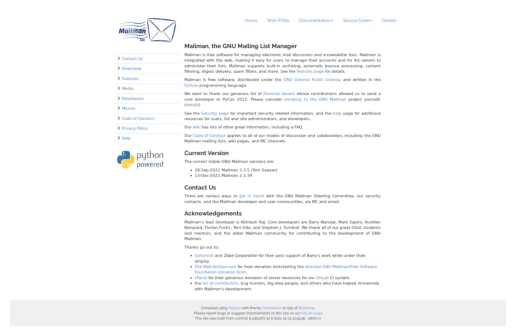

In [585]:
# Take 1655885631145 since it is in huggingface dataset
path = base_data_path / 'train_split_web7k' / '1655885631145'
loader = PageLoader(path, debug=False)

# Show
print(loader.pages.keys())
print('screen_type:', loader.screen_type, 'page_id:', loader.page_id, 'label:', loader.label)
plt.imshow(loader.image())
plt.axis("off")
plt.show()

In [586]:
# AXTree
nodes = loader.best.files[FileType.AXTree]['nodes']
print(type(loader.best.files[FileType.AXTree]))
print(json.dumps(nodes, indent=2, ensure_ascii=False))

<class 'dict'>
[
  {
    "nodeId": "1",
    "ignored": false,
    "role": {
      "type": "internalRole",
      "value": "RootWebArea"
    },
    "name": {
      "type": "computedString",
      "value": "GNU Mailman",
      "sources": [
        {
          "type": "relatedElement",
          "attribute": "aria-labelledby"
        },
        {
          "type": "attribute",
          "attribute": "aria-label"
        },
        {
          "type": "attribute",
          "attribute": "aria-label",
          "superseded": true
        },
        {
          "type": "relatedElement",
          "value": {
            "type": "computedString",
            "value": "GNU Mailman"
          },
          "nativeSource": "title"
        },
        {
          "type": "attribute",
          "attribute": "title",
          "superseded": true
        }
      ]
    },
    "properties": [
      {
        "name": "focusable",
        "value": {
          "type": "booleanOrUndefined",
          "value":

In [587]:
# BB
bb = loader.best.files.get(FileType.BB)

# turn bb keys to int
bb = { int(b_id): b for b_id, b in bb.items() }

print(type(bb))
for b_id, b in bb.items():
    print(b_id, b)

<class 'dict'>
3 {'x': 0, 'y': 0, 'width': 1920, 'height': 1080}
4 {'x': 416, 'y': 30, 'width': 232.375, 'height': 100}
6 {'x': 889, 'y': 0, 'width': 626, 'height': 87}
7 {'x': 889, 'y': 0, 'width': 87, 'height': 87}
8 {'x': 895, 'y': 12.5, 'width': 75, 'height': 62}
9 {'x': 976, 'y': 0, 'width': 124, 'height': 87}
10 {'x': 982, 'y': 12.5, 'width': 112, 'height': 62}
11 {'x': 1100, 'y': 0, 'width': 170, 'height': 87}
12 {'x': 1106, 'y': 12.5, 'width': 158, 'height': 62}
14 {'x': 1270, 'y': 0, 'width': 150, 'height': 87}
15 {'x': 1276, 'y': 12.5, 'width': 138, 'height': 62}
17 {'x': 1420, 'y': 0, 'width': 95, 'height': 87}
18 {'x': 1426, 'y': 12.5, 'width': 83, 'height': 62}
19 {'x': 405, 'y': 211.921875, 'width': 255, 'height': 38.421875}
20 {'x': 405, 'y': 480.875, 'width': 255, 'height': 37.921875}
22 {'x': 433, 'y': 183, 'width': 82, 'height': 18}
24 {'x': 433, 'y': 221.421875, 'width': 75, 'height': 18}
26 {'x': 433, 'y': 259.84375, 'width': 65, 'height': 18}
28 {'x': 433, 'y': 298

In [588]:
# map backendDOMNodeId -> AXTree node
backend_id_to_axnode = {
    node.get("backendDOMNodeId"): node
    for node in nodes
    if "backendDOMNodeId" in node
}

bb_info = {}
for b_id, b in bb.items():
    ax_node = backend_id_to_axnode.get(b_id)
    if not ax_node:
        continue

    bb_info[b_id] = {
        "name": ax_node.get("name", {}).get("value", ""),
        "name_t": ax_node.get("name", {}).get("type", ""),
        "role": ax_node.get("role", {}).get("value", ""),
        "role_t": ax_node.get("role", {}).get("type", ""),
        "ignored": ax_node.get("ignored", False),
        "box": b
    }

# print(type(backend_id_to_axnode), json.dumps(backend_id_to_axnode, indent=2, ensure_ascii=False))
# print(type(bb_info),'\n', json.dumps(bb_info, indent=2, ensure_ascii=False))

In [589]:
ignored_ids = [] 
for x_id, x in bb_info.items():
    if x["role"] == 'LineBreak':
        print(x_id, x['ignored'], x['role_t'], x['role'], '"', x['name'], '"', x['box'])
        ignored_ids.append(x['role'])

print(set(ignored_ids))

138 False internalRole LineBreak "  " {'x': 390, 'y': 1144.078125, 'width': 0, 'height': 0}
141 False internalRole LineBreak "  " {'x': 390, 'y': 1144.078125, 'width': 0, 'height': 0}
{'LineBreak'}


In [590]:
unic = {info["name_t"] for info in bb_info.values()}
print(unic)

{'', 'computedString'}


In [591]:
# roles filter
allowed_roles = {info["role"] for info in bb_info.values()}
print(allowed_roles)
# allowed_roles.discard('StaticText')
# allowed_roles.discard('heading')
# allowed_roles.discard('paragraph')
# allowed_roles.discard('RootWebArea')
# allowed_roles.discard('navigation')

{'table', 'listitem', 'StaticText', 'row', 'none', 'generic', 'link', 'heading', 'list', 'gridcell', 'paragraph', 'navigation', 'LineBreak', 'ListMarker', 'img', 'RootWebArea'}


In [592]:
def rectangle_intersaction_area_pr(p, c):
    if(p["width"] == 0 or p["height"] == 0):
        return 0
    # Координаты пересечения
    x_left   = max(p["x"], c["x"])
    y_bottom = max(p["y"], c["y"])
    x_right  = min(p["x"] + p["width"], c["x"] + c["width"])
    y_top    = min(p["y"] + p["height"], c["y"] + c["height"])
    
    # Проверка: есть ли вообще пересечение
    if x_right > x_left and y_top > y_bottom:
        parent_area = (p["x"] + p["width"]) * (p["y"] + p["height"])
        return (x_right - x_left) * (y_top - y_bottom) / parent_area
    else:
        return 0  # Нет пересечения

In [593]:
nodes_by_id = {node["nodeId"]: node for node in nodes}
# print(type(nodes_by_id), json.dumps(nodes_by_id, indent=2, ensure_ascii=False))

root_node = next(
    node for node in nodes
    if "parentId" not in node or node["parentId"] is None
)
# print(root_node.get("childIds", []))


# def build_tree(node):
#     children = []
#     for child_id in node.get("childIds", []):
#         child_node = nodes_by_id.get(child_id)
#         if child_node:
#             children.append(build_tree(child_node))
#     return {
#         "id": node["nodeId"],
#         "back_id": node.get("backendDOMNodeId"),
#         "ignored": node.get("ignored"),
#         "name": node.get("name", {}).get("value", ""),
#         "role": node.get("role", {}).get("value", ""),
#         "children": children
#     }

def build_tree(node):
    children = []
    for child_id in node.get("childIds", []):
        child_node = nodes_by_id.get(child_id)
        if child_node:
            child_back_id = child_node.get("backendDOMNodeId")
            child_box = bb.get(child_back_id) if child_back_id is not None else None
            parent_back_id = node.get("backendDOMNodeId")
            parent_box = bb.get(parent_back_id) if parent_back_id is not None else None

            # По умолчанию площадь пересечения — 0
            intersection_area = 0
            if parent_box and child_box:
                intersection_area = rectangle_intersaction_area_pr(parent_box, child_box)

            child_tree = build_tree(child_node)
            child_tree["intersection_area"] = intersection_area
            children.append(child_tree)

    return {
        "id": node["nodeId"],
        "back_id": node.get("backendDOMNodeId"),
        "ignored": node.get("ignored"),
        "name": node.get("name", {}).get("value", ""),
        "role": node.get("role", {}).get("value", ""),
        "children": children
    }


tree = build_tree(root_node)
tree["intersection_area"] = 0  # вручную добавляем в корень

def print_tree(node, indent=0):
    if not isinstance(node, dict):
        print("❌ Unexpected node:", node)
        return

    prefix = " " * (indent * 2)
    role = node.get("role", "")
    name = node.get("name", "")
    n_id = node.get("id", "")
    b_id = node.get("back_id", "")
    ignored = node.get("ignored", "")
    intersection = node.get("intersection_area")

    print(f"{prefix}- {b_id} [intersection_area: {intersection:.2f}] ({indent}) ({role}) ({ignored}) ")

    for child in node.get("children", []):
        print_tree(child, indent + 1)

print_tree(tree)

- 3 [intersection_area: 0.00] (0) (RootWebArea) (False) 
  - 115 [intersection_area: 1.00] (1) (none) (True) 
    - 116 [intersection_area: 1.00] (2) (none) (True) 
      - 117 [intersection_area: 1.00] (3) (generic) (False) 
        - 119 [intersection_area: 0.07] (4) (navigation) (False) 
          - 38 [intersection_area: 0.61] (5) (none) (True) 
            - 81 [intersection_area: 0.12] (6) (none) (True) 
              - 122 [intersection_area: 0.00] (7) (none) (True) 
                - 123 [intersection_area: 0.00] (8) (none) (True) 
                  - 124 [intersection_area: 0.00] (9) (none) (True) 
                - 125 [intersection_area: 0.00] (8) (none) (True) 
                - 126 [intersection_area: 0.00] (8) (none) (True) 
                - 127 [intersection_area: 0.00] (8) (none) (True) 
              - 82 [intersection_area: 0.41] (7) (link) (False) 
                - 4 [intersection_area: 0.18] (8) (img) (False) 
            - 128 [intersection_area: 0.74] (6) (gener

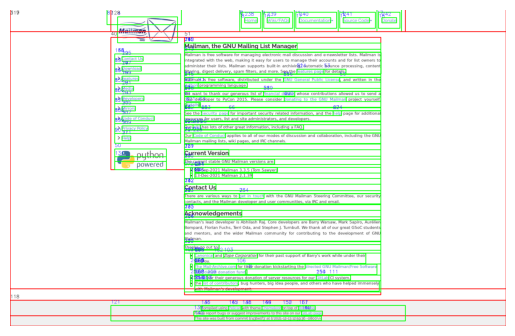

Image saved in: C:\Users\70133\.cache\huggingface\hub\datasets--biglab--webui-7k\snapshots\60f7b3c4b9409f75551664adc1564625dfc33c2e\dataset1\bb\boxed.png


In [594]:
pil_img = loader.image()                                    # WebPImageFile
img_rgb = np.array(pil_img)                                 # RGB
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)          # BGR for OpenCV

# Draw boxes
for b_id, b in bb.items():
    if b is None or b["width"] == 0 or b["height"] == 0:
        continue
    # if not bb_info[b_id]["role_t"] == 'role': continue
    # if not b_id in ignored_ids:
    #     continue
    color_b = (0, 255, 0)
    color_t = (255, 0, 0)
    if b_id in {3, 117, 119, 38, 39, 51, 118, 40, 128, 129}: 
        color_b = (0, 0, 255)
        color_t = (0, 0, 0)

    
    x1, y1 = int(b["x"]), int(b["y"])
    x2 = int(b["x"] + b["width"])
    y2 = int(b["y"] + b["height"])
    
    name = bb_info[b_id]["name"]
    role = bb_info[b_id]["role"]
    text_coordinates = (x1, max(y1 - 8, 0))
    if y1 < 20:
        text_coordinates = (x1, max(y1 + 20, 0))
    # if not bb_info[b_id]["ignored"] and role in allowed_roles:
    if not bb_info[b_id]["ignored"]:
        cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color_b, 2) # Green, width = 2px
        cv2.putText(img_bgr, str(b_id), text_coordinates, cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_t, 1) # Text

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Back to RGB

# Show
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

# Save
out_dir = base_data_path / 'bb'
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "boxed.png"

if not cv2.imwrite(str(out_path), img_bgr):
    raise RuntimeError("error")
print("Image saved in:", out_path)

## Other Bounding Boxes

In [516]:
def get_bb_and_info(filename):
    path = base_data_path / 'train_split_web7k' / filename
    loader = PageLoader(path, debug=False)
    
    # AXTree
    nodes = loader.best.files[FileType.AXTree]['nodes']
    
    # BB
    bb = loader.best.files.get(FileType.BB)
    bb = { int(b_id): b for b_id, b in bb.items() } # turn bb keys to int
    
    # map backendDOMNodeId -> AXTree node
    backend_id_to_axnode = {
        node.get("backendDOMNodeId"): node
        for node in nodes
        if "backendDOMNodeId" in node
    }
    
    bb_info = {}
    for b_id, b in bb.items():
        ax_node = backend_id_to_axnode.get(b_id)
        if not ax_node:
            continue
    
        bb_info[b_id] = {
            "name": ax_node.get("name", {}).get("value", ""),
            # "name_t": ax_node.get("name", {}).get("type", ""),
            "role": ax_node.get("role", {}).get("value", ""),
            # "role_t": ax_node.get("role", {}).get("type", ""),
            "ignored": ax_node.get("ignored", False),
            # "box": b
        }

    # Show
    print(loader.pages.keys())
    print('screen_type:', loader.screen_type, 'page_id:', loader.page_id, 'label:', loader.label)
    plt.imshow(loader.image())
    plt.axis("off")
    plt.show()
    # print(type(loader.best.files[FileType.AXTree]))
    # print(json.dumps(nodes, indent=2, ensure_ascii=False))
    # print(type(bb))
    # for b_id, b in bb.items():
    #     print(b_id, b)
    # print(type(backend_id_to_axnode), json.dumps(backend_id_to_axnode, indent=2, ensure_ascii=False))
    # print(type(bb_info),'\n', json.dumps(bb_info, indent=2, ensure_ascii=False))

    return bb, bb_info, loader.image()

In [522]:
def boxed_image(pil_img, bb, bb_info, out_dir, p_name = ''):
    img_rgb = np.array(pil_img)                                 # RGB
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)          # BGR for OpenCV
    
    # Draw boxes
    for b_id, b in bb.items():
        if b is None or b["width"] == 0 or b["height"] == 0:
            continue
            
        color_b = (0, 255, 0)
        color_t = (255, 0, 0)
        
        x1, y1 = int(b["x"]), int(b["y"])
        x2 = int(b["x"] + b["width"])
        y2 = int(b["y"] + b["height"])
        
        name = bb_info[b_id]["name"]
        role = bb_info[b_id]["role"]
        
        text_coordinates = (x1, max(y1 - 8, 0))
        if y1 < 20:
            text_coordinates = (x1, max(y1 + 20, 0))
            
        if str(role) == p_name:
            cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color_b, 2) # Green, width = 2px
            cv2.putText(img_bgr, str(b_id), text_coordinates, cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_t, 1) # Text
    
    cv2.putText(img_bgr, p_name, (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2) # Text

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Back to RGB
    
    # Show
    # plt.imshow(img_rgb)
    # plt.axis("off")
    # plt.show()

    # Save
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"boxed_{p_name}.png"
    
    if not cv2.imwrite(str(out_path), img_bgr):
        raise RuntimeError("error")
    print(f"Role:{p_name}. Image saved in:", out_path)

In [ ]:
# sites_to_go = {'1655885631145', '1655888953458', '1655890112189'}

for site in sites_to_go:
    bb1, bb_info1, img = get_bb_and_info(site)
    
    allowed_roles1 = {info["role"] for info in bb_info1.values()}
    print(allowed_roles1)
    
    out_dir1 = base_data_path / 'bb' / site
    
    for role in allowed_roles1:
        boxed_image(img, bb1, bb_info1, out_dir1, role)

In [ ]:
roles_unic = {'complementary', 'figure', 'button', 'tab', 'none', 'LayoutTableCell', 'tablist', 'article', 'IframePresentational',
              'Legend', 'navigation', 'gridcell', 'Section', 'spinbutton', 'DisclosureTriangle', 'img', 'DescriptionList', 'searchbox',
              'RootWebArea', 'group', 'Figcaption', 'row', 'Iframe', 'combobox', 'Pre', 'heading', 'menubar', 'DescriptionListDetail', 'menu',
              'separator', 'region', 'LineBreak', 'HeaderAsNonLandmark', 'columnheader', 'emphasis', 'listbox', 'rowheader', 'form', 'option',
              'textbox', 'link', 'LabelText', 'MenuListPopup', 'contentinfo', 'alertdialog', 'FooterAsNonLandmark', 'dialog', 'paragraph',
              'status', 'ListMarker', 'main', 'switch', 'Video', 'Abbr', 'tabpanel', 'grid', 'time', 'table', 'StaticText', 'listitem',
              'DescriptionListTerm', 'insertion', 'PluginObject', 'checkbox', 'menuitem', 'superscript', 'generic', 'banner', 'list',
              'LayoutTableRow', 'strong', 'LayoutTable', 'search', 'blockquote', 'Details'}
print(sorted(roles_unic))